# Classifying Melanoma Tumor Images 

The first step is to import all the library and modules that will be required for this project.

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from functools import partial
from sklearn.model_selection import train_test_split
import tempfile
import matplotlib.pyplot as plt
import pydicom 
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import cv2

sns.set_style("whitegrid")


In [ ]:
!pip install -q efficientnet_pytorch             # Convolutional Neural Net from Google Research

In [ ]:
# System
import cv2
import os, os.path
from PIL import Image              # from RBG to YCbCr
import gc
import time
import datetime

# Basics
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg    # to check images
# %matplotlib inline
from tqdm.notebook import tqdm      # beautiful progression bar

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate)
from albumentations.pytorch import ToTensorV2, ToTensor

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50

import warnings
warnings.filterwarnings("ignore")

In [ ]:
list(os.listdir('../input/siim-isic-melanoma-classification'))

# Data Cleaning and EDA 

The first step is to do some initial data exploration. There are around 33,000 images in the training dataset adn around 11,000 images in the test dataset. 

In [ ]:
directory = '../input/siim-isic-melanoma-classification'

train_df = pd.read_csv(directory + '/train.csv')
test_df = pd.read_csv(directory + '/test.csv')

print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df), len(test_df)))

new_names = ['image_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
train_df.isnull().sum()

In [ ]:
test_df.isnull().sum()

In the training dataset there are 65 missing values for sex, 68 missing values for age, and 527 missing values for anatomy. For the test dataset there are 351 values missing for anatomy. This number of missing values is not too bad since the datasets are pretty large. By visualizing the missing values by sex and anatomical distribution we can see what value might be best to fill in the NaN values. 

In [ ]:
nan_sex = train_df[train_df['sex'].isna() == True]
is_sex = train_df[train_df['sex'].isna() == False]

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(nan_sex['anatomy'], ax = ax1)
b = sns.countplot(is_sex['anatomy'], ax = ax2)
ax1.set_title('NAN Gender: Anatomy', fontsize=16)
ax2.set_title('Rest Gender: Anatomy', fontsize=16)

a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")
sns.despine(left=True, bottom=True);

print('Out of 65 NAN values, {} are benign and 0 malignant.'.format(nan_sex['benign_malignant'].value_counts()[0]))

Since the torso is by far the most common location for melanomas based on the graph on the right and is the second most common location for melanomas based on the graph on the left, this is the location I will use to fill in missing location values.

In [ ]:
train_df['anatomy'].fillna('torso', inplace = True) 

In [ ]:
train_df.isnull().sum()

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(test_df['anatomy'])

In [ ]:
test_df['anatomy'].fillna('torso', inplace = True) 
test_df.isnull().sum()

To fill in missing age values I will look at both mean age, the median age and the general distribution of ages. In order to fill in the missing values for sex of the patients I will visualize how many male and female patients there are in total and fill in values with the more prominent category. 

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(train_df['age'])

In [ ]:
train_df['age'].mean()

In [ ]:
train_df['age'].median()

In [ ]:
train_df['age'].fillna(50, inplace = True) 

In [ ]:
train_df.isnull().sum()

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(train_df['sex'])

In [ ]:
train_df['sex'].fillna('male', inplace = True) 

In [ ]:
train_df.isnull().sum()

In [ ]:
test_df.isnull().sum()

In [ ]:
train_df.head()

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(train_df['benign_malignant'])

The classes of benign and malignant samples are extremely unbalanced, an issue that will need to be addressed before a model can be accurately fit to the data. One way to deal with unbalanced classes is to undersample from the majority class, however in this case it would lead to a large loss of data. The other option is to oversample from the minority class. For image analysis one way of doing this is to change aspects of the images such as color and shading to create more images that can be used to train the model on this class of images, in this case the malignant melanoma tumors. 

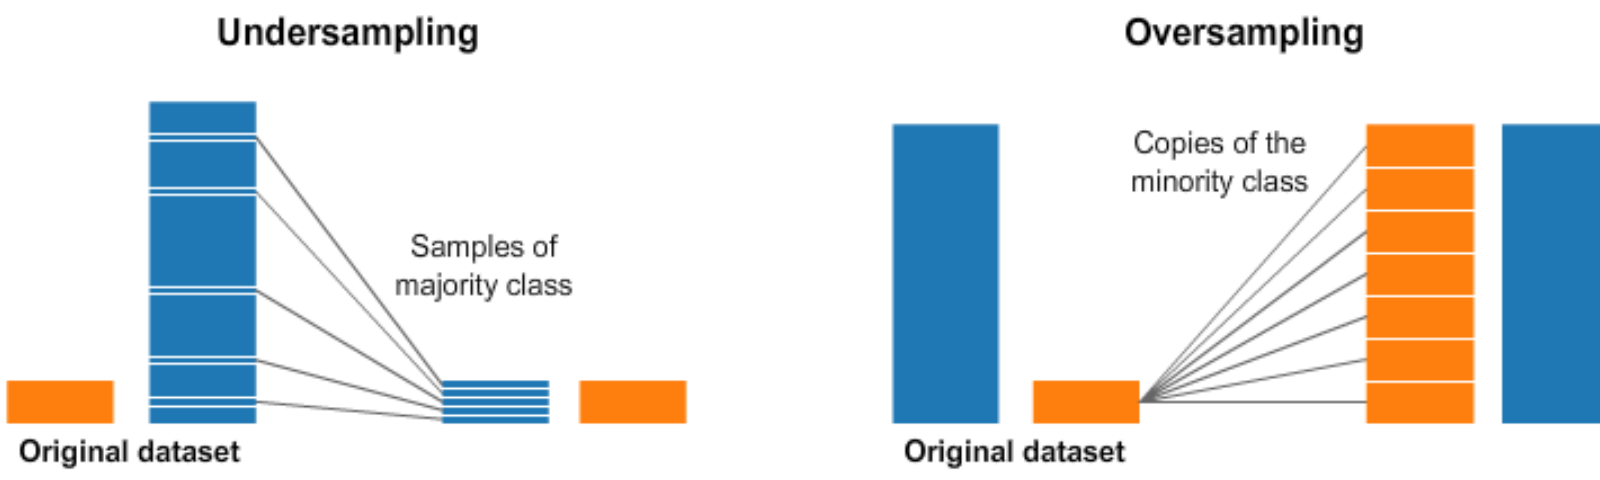

In [ ]:
train_df.to_csv('train_clean.csv', index=False)
test_df.to_csv('test_clean.csv', index=False)

We can explore the relationship of malignant and benign diagnoses related to age. The malignant curve is much smoother as there are far fewer values 

In [ ]:
plt.figure(figsize=(15,8))
sns.distplot(a = train_df[train_df['target']==0]['age'], hist=False, rug=True, kde_kws=dict(linewidth=4), 
             label='Benign')
sns.distplot(a = train_df[train_df['target']==1]['age'], hist=False, rug=True, kde_kws=dict(linewidth=4), 
             label='Malignant')
plt.title('Age Distribution by Target Types', fontsize=16)

In [ ]:
plt.figure(figsize=(16, 6))
sns.countplot(data=train_df, x='benign_malignant', hue='sex')
plt.title('Gender Split by Target Variable', fontsize=16)

There are more benign and malignant cases for men than for women, so this does not appear to be a major factor in diagnosis at first glance. 

In [ ]:
plt.figure(figsize=(16, 6))
sns.countplot(data=train_df, x='benign_malignant', hue='anatomy')
plt.title('Anatomy Split by Target Variable', fontsize=16)

The torso is by far the most common location for melanoma tumors, for both benign and malignant cases. 

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 6))

a = sns.countplot(test_df['sex'], ax=ax1)
b = sns.countplot(test_df['anatomy'], ax=ax2)
c = sns.distplot(a = test_df['age'], ax=ax3, hist=False, rug=True, kde_kws=dict(linewidth=4))


ax1.set_title('Test: Gender Frequencies', fontsize=16)
ax2.set_title('Test: Anatomy Frequencies', fontsize=16)
ax3.set_title('Test: Age Distribution', fontsize=16)

In [ ]:
patients_count_train = train_df.groupby(by='ID')['image_name'].count().reset_index()
patients_count_test = test_df.groupby(by='ID')['image_name'].count().reset_index()

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.distplot(patients_count_train['image_name'], kde=False, bins=50, 
                 ax=ax1, hist_kws={'alpha': 1})
b = sns.distplot(patients_count_test['image_name'], kde=False, bins=50, 
                 ax=ax2, hist_kws={'alpha': 1})
    
ax1.set_title('Train: Images per Patient Distribution', fontsize=16)
ax2.set_title('Test: Images per Patient Distribution', fontsize=16)
sns.despine(left=True, bottom=True);

You can see that there are patients with multiple images taken in both the test and training datasets.

In [ ]:
train_df.to_csv('train_clean.csv', index=False)
test_df.to_csv('test_clean.csv', index=False)

Next we will create image paths to allow us to access image features for the images as dicoms and as jpegs. We can create the paths and then store them as new columns in the existing training and testing dataframes. 

In [ ]:
path_train = directory + '/train/' + train_df['image_name'] + '.dcm'
path_test = directory + '/test/' + test_df['image_name'] + '.dcm'

train_df['path_dicom'] = path_train
test_df['path_dicom'] = path_test

path_train = directory + '/jpeg/train/' + train_df['image_name'] + '.jpg'
path_test = directory + '/jpeg/test/' + test_df['image_name'] + '.jpg'

train_df['path_jpeg'] = path_train
test_df['path_jpeg'] = path_test

The categorical features will need to be converted to numerical features through one-hot encoding. Although some machine learning algorithms such as decision trees can handle categorical values, for the convolutional neural networks used in creating this model we will need to use numerical features. 

In [ ]:
train_df.drop(['benign_malignant'], axis=1, inplace=True)
train_df.head()

In [ ]:
test_df.head()

In [ ]:
to_encode = ['sex', 'anatomy', 'diagnosis']
encoded_all = []

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(train_df[column])
    encoded_all.append(encoded)
    
train_df['sex'] = encoded_all[0]
train_df['anatomy'] = encoded_all[1]
train_df['diagnosis'] = encoded_all[2]

In [ ]:
train_df.head()

In [ ]:
to_encode = ['sex', 'anatomy']
encoded_all = []

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(test_df[column])
    encoded_all.append(encoded)
    
test_df['sex'] = encoded_all[0]
test_df['anatomy'] = encoded_all[1]

In [ ]:
test_df.head()

In [ ]:
train_df.to_csv('train_clean.csv', index=False)
test_df.to_csv('test_clean.csv', index=False)

Next I will add the image heights and widths to a dataframe and visually examine the distribution of shape sizes. The graph shows that there is a variety of shapes, at least in the first 100 images. In order to train the model we will need to make the images similar sizes, so this will be addressed in data augmentation. 

In [ ]:
shapes_train = []

for k, path in enumerate(train_df['path_jpeg']):
    image = Image.open(path)
    shapes_train.append(image.size)
    
    if k >= 100: break
        
shapes_train = pd.DataFrame(data = shapes_train, columns = ['H', 'W'], dtype='object')
shapes_train['Size'] = '[' + shapes_train['H'].astype(str) + ', ' + shapes_train['W'].astype(str) + ']'

In [ ]:
shapes_train.head()

In [ ]:
plt.figure(figsize = (16, 6))
sns.countplot(shapes_train['Size'])
plt.title('100 Images Shapes', fontsize=16)

Next we will view a sample of the benign and malignant melanoma images from the dataset.

In [ ]:
def show_images(data, n = 5, rows=1, cols=5, title='Default'):
    plt.figure(figsize=(16,4))

    for k, path in enumerate(data['path_dicom'][:n]):
        image = pydicom.read_file(path)
        image = image.pixel_array
        
        # image = resize(image, (200, 200), anti_aliasing=True)

        plt.suptitle(title, fontsize = 16)
        plt.subplot(rows, cols, k+1)
        plt.imshow(image)
        plt.axis('off')

In [ ]:
show_images(train_df[train_df['target'] == 0], n=10, rows=2, cols=5, title='Benign Sample')

In [ ]:
show_images(train_df[train_df['target'] == 1], n=10, rows=2, cols=5, title='Malignant Sample')

# Data Augmentation

During the data exploration part of the project, I saw that the classes of malignant and benign images are highly unbalanced. There are far more benign images than malignant, and as discussed we will be oversampling the malignant images. However, if we merely oversample the same set of images, the model may start overfitting the data. One way to combat this effect is to make small alterations to the images such as changing the color scheme, flipping them, etc. To the model they will seem like completely different images. 

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("B&W", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

Next we will convert the images from RGB to HSV or hue saturation values, an alternative representation of the RGB color model. 

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("RGB to HSV", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array

    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

We can use a Gaussian function to blur the images. 

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("With Gaussian Blur", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image = cv2.resize(image, (200,200))
    image=cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0) ,256/10), -4, 128)
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("Hue, Saturation, Brightness", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

LUV is another alterntive to the RGB color model. 

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("LUV Color Space", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array

    image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

In [ ]:
image_list = train_df.sample(12)['path_jpeg']
image_list = image_list.reset_index()['path_jpeg']

In [ ]:
class DatasetExample(Dataset):
    def __init__(self, image_list, transforms=None):
        self.image_list = image_list
        self.transforms = transforms
    
    # To get item's length
    def __len__(self):
        return (len(self.image_list))
    
    # For indexing
    def __getitem__(self, i):
        # Read in image
        image = plt.imread(self.image_list[i])
        image = Image.fromarray(image).convert('RGB')        
        image = np.asarray(image).astype(np.uint8)
        if self.transforms is not None:
            image = self.transforms(image)
            
        return torch.tensor(image, dtype=torch.float)

In [ ]:
def show_transform(image, title="Default"):
    plt.figure(figsize=(16,6))
    plt.suptitle(title, fontsize = 16)
    
    # Unnormalize
    image = image / 2 + 0.5  
    npimg = image.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms 
import torch 
import torchvision

In [ ]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.CenterCrop((100, 100)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

# Create the dataset
pytorch_dataset = DatasetExample(image_list=image_list, transforms=transform)
pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=12, shuffle=True)

# Select the data
images = next(iter(pytorch_dataloader))
 
# show images
show_transform(torchvision.utils.make_grid(images, nrow=6), title="Crop")

We will perform a couple more color transformations as well as randomly flipping images vertically and horizontally. All of these transformation should be sufficient to build a large number of malignant images for the model to be trained on. 

In [ ]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7, hue=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

# Create the dataset
pytorch_dataset = DatasetExample(image_list=image_list, transforms=transform)
pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=12, shuffle=True)

# Select the data
images = next(iter(pytorch_dataloader))
 
# show images
show_transform(torchvision.utils.make_grid(images, nrow=6), title="Color Jitter")

In [ ]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.RandomGrayscale(p=0.7),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

# Create the dataset
pytorch_dataset = DatasetExample(image_list=image_list, transforms=transform)
pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=12, shuffle=True)

# Select the data
images = next(iter(pytorch_dataloader))
 
# show images
show_transform(torchvision.utils.make_grid(images, nrow=6), title="Random Greyscale")

In [ ]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.RandomVerticalFlip(p=0.7),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

# Create the dataset
pytorch_dataset = DatasetExample(image_list=image_list, transforms=transform)
pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=12, shuffle=True)

# Select the data
images = next(iter(pytorch_dataloader))
 
# show images
show_transform(torchvision.utils.make_grid(images, nrow=6), title="Random Vertical Flip")

Hairs can be seen in many of the images. Since we do not want to end up training the model to see patterns in the presence of hairs rather than the actual melanoma lesions these will need to be removed. 

In [ ]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel = cv2.getStructuringElement(1,(17,17))

    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
   
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)

    return final_image

In [ ]:
hairy_photos = train_df[train_df["sex"] == 1].reset_index().iloc[[12, 14, 17, 22, 33, 34]]
image_list = hairy_photos['path_jpeg']
image_list = image_list.reset_index()['path_jpeg']

In [ ]:
plt.figure(figsize=(16,3))
plt.suptitle("Original Hairy Images", fontsize = 16)
    
for k, path in enumerate(image_list):
    image = mpimg.imread(path)
    image = cv2.resize(image,(300, 300))
        
    plt.subplot(1, 6, k+1)
    plt.imshow(image)
    plt.axis('off')

In [ ]:
plt.figure(figsize=(16,3))
plt.suptitle("Non Hairy Images", fontsize = 16)
    
for k, path in enumerate(image_list):
    image = mpimg.imread(path)
    image = cv2.resize(image,(300, 300))
    image = hair_remove(image)
        
    plt.subplot(1, 6, k+1)
    plt.imshow(image)
    plt.axis('off')